 ## PERTEMUAN 5
 ## Building, Tuning, dan Deploying Model Machine Learning


*   Nama : Kinanti Anggraeni
*   NIM : 4112322010



### Import Library


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

### 1. Eksplorasi Data

*   Identifikasi apakah terdapat missing values dalam dataset.
*   Visualisasikan data



In [2]:
df = pd.read_csv('/content/loan_approval_dataset.csv')
df

,Age,Income,Education_Level,Credit_Score,Loan_Amount,Loan_Purpose,Loan_Approval
0,56,24000,PhD,333,26892,Personal,0
1,46,90588,Master,316,26619,Home,1
2,32,113610,PhD,452,1281,Personal,1
3,60,117856,High School,677,28420,Personal,0
4,25,58304,PhD,641,16360,Car,0
...,...,...,...,...,...,...,...
495,37,108236,High School,455,44668,Education,1
496,41,117579,Bachelor,666,24177,Car,1
497,29,26469,PhD,550,25022,Medical,0
498,52,50105,High School,633,41761,Medical,0


#### Cek Missing Value

In [3]:
df.isnull().sum()

,0
Age,0
Income,0
Education_Level,0
Credit_Score,0
Loan_Amount,0
Loan_Purpose,0
Loan_Approval,0


Setelah di cek tidak terdapat missing value dalam dataset ini

In [4]:
df.describe()

,Age,Income,Credit_Score,Loan_Amount,Loan_Approval
count,500.000000,500.00000,500.00000,500.000000,500.000000
mean,41.278000,67210.16800,572.37800,26526.744000,0.596000
std,13.389072,28908.77426,159.71466,13931.322188,0.491189
min,18.000000,20055.00000,301.00000,1125.000000,0.000000
25%,30.000000,42534.25000,432.00000,13327.500000,0.000000
50%,42.000000,64906.50000,584.00000,27985.500000,1.000000
75%,52.000000,93071.25000,698.50000,38381.000000,1.000000
max,64.000000,119835.00000,848.00000,49938.000000,1.000000


#### Visualisasi Data

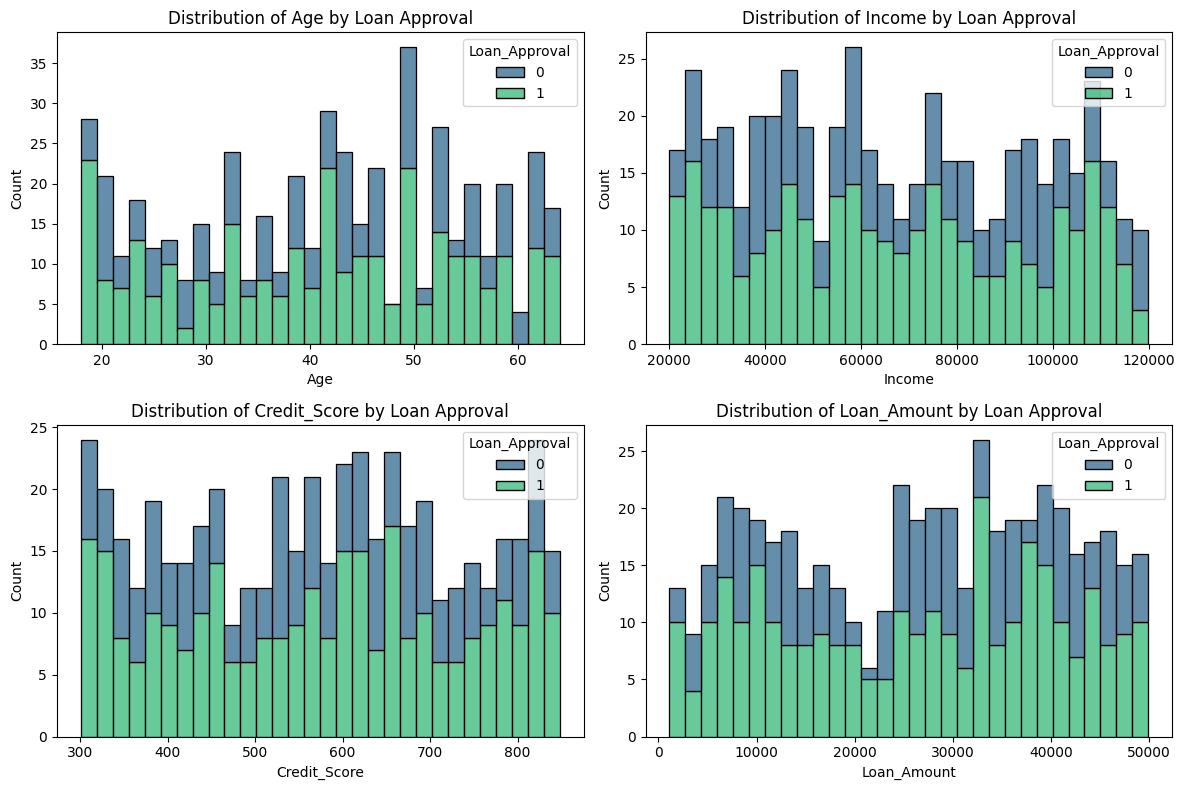

In [5]:
numerical_features = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, feature in enumerate(numerical_features):
    ax = axes[idx // 2, idx % 2]
    sns.histplot(
        data=df,
        x=feature,
        hue='Loan_Approval',
        bins=30,
        multiple='stack',
        palette='viridis',
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f'Distribution of {feature} by Loan Approval')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

1. Terdapat tren bahwa pemohon dengan skor kredit lebih tinggi memiliki tingkat persetujuan pinjaman yang lebih besar, meskipun masih ada penolakan di semua rentang skor.

2. Pendapatan dan usia tidak menunjukkan perbedaan signifikan dalam tingkat persetujuan.

3. Pemohon dengan jumlah pinjaman yang lebih kecil cenderung memiliki tingkat persetujuan yang lebih tinggi dibandingkan dengan yang mengajukan jumlah besar.

<Figure size 1200x800 with 0 Axes>

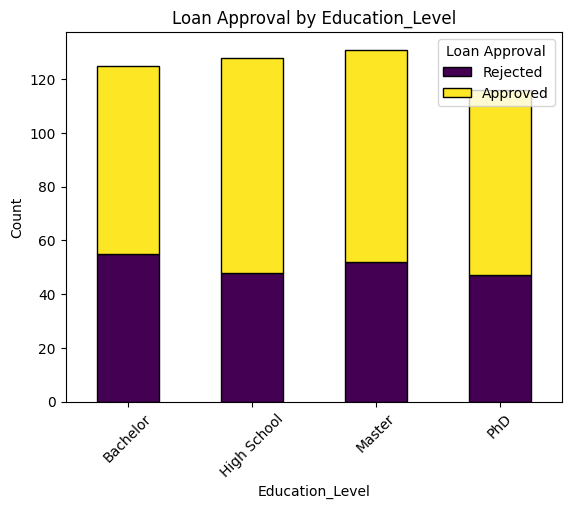

<Figure size 1200x800 with 0 Axes>

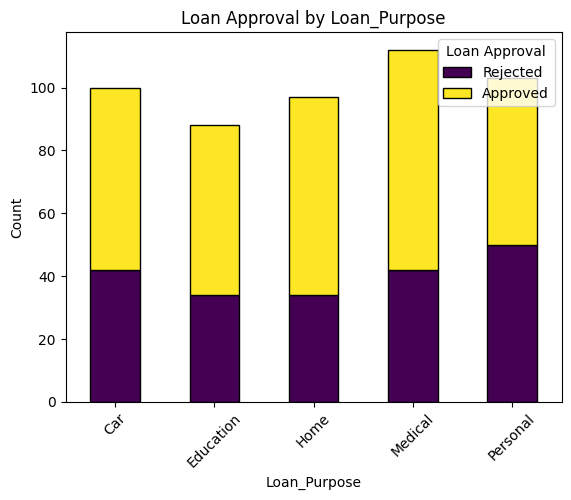

In [6]:
categorical_features = ['Education_Level', 'Loan_Purpose']

for cat_feature in categorical_features:
    plt.figure(figsize=(12, 8))
    cat_approval = df.groupby([cat_feature, 'Loan_Approval']).size().unstack()
    cat_approval.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
    plt.title(f'Loan Approval by {cat_feature}')
    plt.xlabel(cat_feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Loan Approval', labels=['Rejected', 'Approved'])
    plt.show()

1. Pendidikan dengan gelar Master tampaknya memiliki peluang persetujuan pinjaman yang lebih baik. Namun, perbedaan antar tingkat pendidikan tidak terlalu signifikan.

2. Tujuan pinjaman cukup berpengaruh terhadap tingkat persetujuan. Pinjaman dengan tujuan yang lebih "mendesak" atau jelas seperti medis = cenderung disetujui lebih mudah dibandingkan tujuan pribadi.

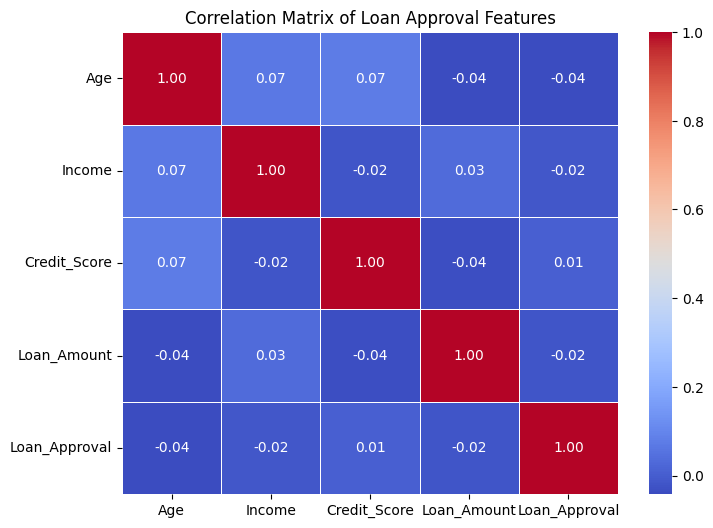

In [7]:
numerical_features = ['Age', 'Income', 'Credit_Score', 'Loan_Amount', 'Loan_Approval']

plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Loan Approval Features')
plt.show()

Tidak ada variabel yang memiliki korelasi kuat dengan Loan Approval. Semua nilai korelasi dengan Loan_Approval sangat kecil, berkisar antara -0.04 hingga 0.01, yang berarti tidak ada hubungan linear yang signifikan antara faktor-faktor ini dengan persetujuan pinjaman.



### 2. Pemrosesan Data

*   Lakukan encoding pada fitur kategorikal
*   Lakukan feature scaling pada fitur numerik
*   Bagi dataset menjadi training set (80%) dan testing set (20%).





#### Encoding

In [8]:
df_new = pd.get_dummies(df, columns=['Education_Level', 'Loan_Purpose'], drop_first=True)
df_new = df_new.astype(int)

Setiap kategori unik dalam fitur yang di-encode akan menjadi kolom baru. Misalnya, fitur Education level dengan 4 kategori, setelah One-Hot Encoding, akan mendapatkan 3 kolom baru (karena menggunakan drop_first=True untuk menghindari multikolinearitas).

Dengan kata lain jika memiliki fitur dengan n kategori, maka One-Hot Encoding akan menambah n-1 kolom baru ke dataset.

#### Splitting dataset

In [9]:
X = df_new.drop(columns=['Loan_Approval'])
y = df_new['Loan_Approval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting ini memastikan bahwa model dapat belajar dengan baik dari data latih dan diuji pada data yang belum pernah dilihat, sehingga hasil prediksi lebih andal.

#### Scaling

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

StandardScaler() digunakan untuk menstandarkan data dengan cara mengubahnya ke skala dengan mean = 0 dan standard deviation = 1

Scaling ini memastikan bahwa semua fitur numerik memiliki skala yang sama, sehingga model machine learning dapat bekerja lebih optimal dan memberikan hasil yang lebih akurat.

### 3. Pemilihan dan Training Model
*   Pilih minimal dua algoritma Machine Learning yang berbeda.
*   Lakukan training model menggunakan dataset yang telah diproses.



#### Logistic Regression

Logistic Regression dipilih karena kemampuannya dalam menangani masalah klasifikasi biner dengan baik, terutama ketika hubungan antar fitur tidak terlalu kuat. Dari hasil analisis korelasi, tidak ditemukan hubungan yang sangat signifikan antar fitur, sehingga metode ini tetap efektif. Selain itu, logistic regression mudah diinterpretasikan, karena memberikan bobot pada setiap fitur, memungkinkan kita memahami sejauh mana faktor seperti usia, pendapatan, skor kredit, dan jumlah pinjaman memengaruhi keputusan persetujuan.

In [12]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.22      0.05      0.09        37
           1       0.62      0.89      0.73        63

    accuracy                           0.58       100
   macro avg       0.42      0.47      0.41       100
weighted avg       0.47      0.58      0.49       100



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model ini memiliki recall tinggi untuk kelas 1 (89%), yang berarti cukup baik dalam mengidentifikasi pinjaman yang disetujui. Namun, performanya untuk kelas 0 sangat buruk dengan recall hanya 5%, sehingga model ini kurang seimbang.

####  Random Forest Classifier

Random Forest dipilih karena kemampuannya dalam menangkap pola non-linear dalam data. Algoritma ini menggunakan pendekatan ensemble dengan menggabungkan banyak pohon keputusan, sehingga lebih stabil dan tidak rentan terhadap overfitting dibandingkan decision tree tunggal. Selain itu, random forest mampu memberikan informasi mengenai feature importance, sehingga dapat membantu dalam memahami faktor-faktor utama yang berkontribusi dalam persetujuan pinjaman. Keunggulan lainnya adalah kemampuannya dalam menangani dataset dengan jumlah fitur yang tidak terlalu banyak, serta memberikan hasil yang lebih andal dalam kondisi data yang kompleks.

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.34      0.32      0.33        37
           1       0.62      0.63      0.62        63

    accuracy                           0.52       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.51      0.52      0.52       100



Model ini memiliki performa lebih seimbang dibandingkan Logistic Regression, dengan recall yang lebih baik untuk kelas 0 (32%). Namun, akurasinya justru lebih rendah, hanya 52%.



#### Support Vector Machine

Support Vector Machine (SVM) dipilih karena efektif dalam menangani data berdimensi kecil hingga sedang, seperti dataset yang digunakan dalam penelitian ini. Dengan menggunakan kernel trick, SVM dapat memodelkan hubungan yang tidak linear antara variabel independen dan keputusan persetujuan pinjaman. SVM juga bekerja lebih optimal pada data yang telah di-scaling, seperti yang telah dilakukan dalam tahap preprocessing.

In [14]:
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.43      0.08      0.14        37
           1       0.63      0.94      0.76        63

    accuracy                           0.62       100
   macro avg       0.53      0.51      0.45       100
weighted avg       0.56      0.62      0.53       100



SVM memiliki akurasi tertinggi di antara model lainnya (62%). Namun, performa untuk kelas 0 sangat buruk dengan recall hanya 8%. Artinya, model ini lebih banyak mengklasifikasikan data sebagai kelas 1 (disetujui).

#### XGBoost Classifier

XGBoost Classifier dipilih karena dikenal sebagai salah satu metode boosting yang kuat dalam menangani masalah klasifikasi. Algoritma ini memiliki keunggulan dalam performa tinggi dan efisiensi komputasi, serta mampu menangani data yang tidak seimbang dengan baik menggunakan parameter scale_pos_weight. XGBoost sangat cocok untuk dataset yang memiliki jumlah fitur terbatas tetapi mengandung pola yang kompleks, sehingga memungkinkan model untuk menangkap hubungan yang lebih mendalam

In [101]:
xgboost = XGBClassifier(random_state=0)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
y_pred_xgb_prob = xgboost.predict_proba(X_test)[:,1]
accuracy = accuracy_score(y_test, y_pred_xgb)
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_xgb)
print(f'XGBoost Classifier Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.36      0.35      0.36        37
           1       0.62      0.63      0.63        63

    accuracy                           0.53       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.53      0.53      0.53       100



XGBoost memiliki akurasi sedikit lebih baik dari Random Forest (53% vs 52%) dan performa lebih seimbang antara kelas 0 dan 1 dibandingkan Logistic Regression dan SVM.

### 4. Evaluasi Model


*   Hitung dan bandingkan metric evaluasi dari model yang dipilih.
*   Pilih model dengan performa terbaik untuk tahap tuning.




In [104]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support

evaluation_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

def evaluate_model(name, y_test, y_pred):
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    evaluation_metrics['Precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    evaluation_metrics['Recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    # Call the f1_score function correctly using sklearn.metrics.f1_score:
    evaluation_metrics['F1 Score'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

evaluate_model('Logistic Regression', y_test, y_pred_log)
evaluate_model('Random Forest', y_test, y_pred_rf)
evaluate_model('SVM', y_test, y_pred_svm)
evaluate_model('XGBoost Classifier', y_test, y_pred_xgb)

eval_df = pd.DataFrame(evaluation_metrics)
print(eval_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression      0.58   0.418803  0.471471  0.407115
1        Random Forest      0.52   0.479121  0.479622  0.479167
2                  SVM      0.62   0.531490  0.508795  0.446387
3   XGBoost Classifier      0.53   0.493056  0.493136  0.493043


Dari hasil evaluasi ini, SVM memiliki akurasi tertinggi (62%), namun model ini mengalami ketidakseimbangan dalam mengenali kelas 0. Sedangkan XGBoost seimbangan antara dua kelas yang memiliki distribusi metrik yang lebih merata antara kelas 0 dan 1. Sehinngga tuning akan dilakukan pada model XGBoost



### 5. Tuning Model dengan Grid Search atau Random Search

*   Gunakan Grid Search atau Random Search untuk mencari kombinasi hyperparameter
terbaik.
*   Tampilkan kombinasi hyperparameter terbaik yang diperoleh.



In [21]:
!pip install scikit-learn
from sklearn.model_selection import RandomizedSearchCV # Import the necessary class
from xgboost import XGBClassifier

In [174]:
xgb_clf = XGBClassifier()

In [175]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [188]:
rs_model = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=params,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=1,
    cv=5,
    verbose=3,
    random_state=42,
    error_score='raise'
)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6;, score=0.511 total time=   1.6s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6;, score=0.536 total time=   1.2s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6;, score=0.441 total time=   2.0s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6;, score=0.621 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6;, score=0.417 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.554 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6;, score=0.469 total time=   0.1s
[CV 3/5

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           i...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [189]:
# Menampilkan parameter terbaik
print("Best parameters found: ", rs_model.best_params_)

Best parameters found:  {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


Hasil tuning menggunakan RandomizedSearchCV menunjukkan kombinasi hyperparameter terbaik untuk model XGBoostClassifier terdiri dari subsample 1.0, n_estimators 200, max_depth 3, learning_rate 0.01, dan colsample_bytree 1.0.

### 6. Perbandingan Performa Sebelum dan Sesudah Tuning

*   Bandingkan hasil evaluasi model sebelum dan sesudah tuning.
*   Jelaskan apakah tuning berhasil meningkatkan performa model.



In [190]:
# Menggunakan model terbaik untuk prediksi
best_xgb = rs_model.best_estimator_

In [191]:
# Evaluasi model
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classifier Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.17      0.03      0.05        37
           1       0.62      0.92      0.74        63

    accuracy                           0.59       100
   macro avg       0.39      0.47      0.39       100
weighted avg       0.45      0.59      0.48       100



Setelah tuning, akurasi model meningkat dari 0.53 menjadi 0.59, yang menunjukkan adanya perbaikan performa. Namun, perbaikan ini tidak merata di semua metrik. Recall untuk kelas 1 meningkat signifikan dari 0.63 menjadi 0.92, menunjukkan bahwa model lebih baik dalam mengidentifikasi sampel positif. Namun, precision untuk kelas 0 menurun drastis dari 0.36 menjadi 0.17, yang berarti model lebih banyak salah mengklasifikasikan kelas 0 sebagai kelas 1.

Secara keseluruhan, tuning berhasil meningkatkan kemampuan model dalam menangkap kasus positif (recall lebih tinggi), tetapi terjadi trade-off pada keseimbangan prediksi antara dua kelas, terutama dengan menurunnya performa untuk kelas 0.